In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
import re


In [2]:
df = pd.read_csv("/kaggle/input/twitter-airline-sentiment/Tweets.csv")
df.head()


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [5]:
df.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

In [6]:
df = df[['text', 'airline_sentiment']].dropna()

# If you only want binary (pos vs neg) to match “positive or negative”
df = df[df['airline_sentiment'] != 'neutral']  # drop neutral
df['airline_sentiment'].value_counts()


airline_sentiment
negative    9178
positive    2363
Name: count, dtype: int64

In [7]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)      # remove links
    text = re.sub(r"@\w+", "", text)         # remove mentions
    text = re.sub(r"[^a-z\s]", "", text)     # keep letters and spaces
    text = re.sub(r"\s+", " ", text).strip() # remove extra spaces
    return text

df['clean_text'] = df['text'].apply(clean_text)
df[['text','clean_text']].head()


,text,clean_text
1,@VirginAmerica plus you've added commercials t...,plus youve added commercials to the experience...
3,@VirginAmerica it's really aggressive to blast...,its really aggressive to blast obnoxious enter...
4,@VirginAmerica and it's a really big bad thing...,and its a really big bad thing about it
5,@VirginAmerica seriously would pay $30 a fligh...,seriously would pay a flight for seats that di...
6,"@VirginAmerica yes, nearly every time I fly VX...",yes nearly every time i fly vx this ear worm w...


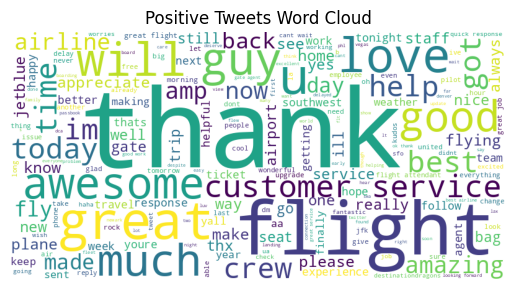

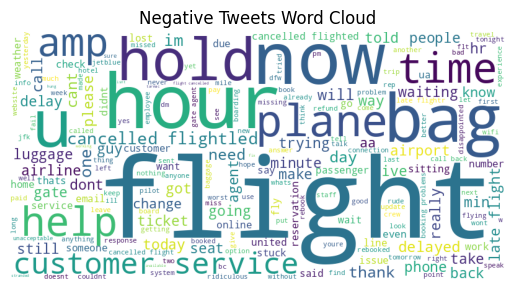

In [8]:
pos_text = " ".join(df[df['airline_sentiment']=="positive"]['clean_text'])
neg_text = " ".join(df[df['airline_sentiment']=="negative"]['clean_text'])

# positive word cloud
wc_pos = WordCloud(width=800, height=400, background_color='white').generate(pos_text)
plt.imshow(wc_pos)
plt.axis('off')
plt.title("Positive Tweets Word Cloud")
plt.show()

# negative word cloud
wc_neg = WordCloud(width=800, height=400, background_color='white').generate(neg_text)
plt.imshow(wc_neg)
plt.axis('off')
plt.title("Negative Tweets Word Cloud")
plt.show()


In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    df['clean_text'],
    df['airline_sentiment'],
    test_size=0.2,
    random_state=42,
    stratify=df['airline_sentiment']
)


In [10]:
tfidf = TfidfVectorizer(
    max_features=5000,   # enough for tweets
    ngram_range=(1,2),   # unigrams + bigrams
    stop_words='english' # can help a bit
)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


In [11]:
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_tfidf, y_train)


LogisticRegression(max_iter=1000)

In [12]:
y_pred = clf.predict(X_test_tfidf)

acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)

print("\nClassification report:\n")
print(classification_report(y_test, y_pred))


Accuracy: 0.895625812039844

Classification report:

              precision    recall  f1-score   support

    negative       0.89      0.99      0.94      1836
    positive       0.91      0.55      0.68       473

    accuracy                           0.90      2309
   macro avg       0.90      0.77      0.81      2309
weighted avg       0.90      0.90      0.89      2309



In [13]:
sample_texts = [
    "I love flying with United, great service!",
    "The flight was delayed for 3 hours, terrible.",
    "Crew was nice but the seat was uncomfortable."
]

clean_samples = [clean_text(t) for t in sample_texts]
sample_vec = tfidf.transform(clean_samples)
sample_preds = clf.predict(sample_vec)

for t, p in zip(sample_texts, sample_preds):
    print(f"Tweet: {t}\nPredicted sentiment: {p}\n")


Tweet: I love flying with United, great service!
Predicted sentiment: positive

Tweet: The flight was delayed for 3 hours, terrible.
Predicted sentiment: negative

Tweet: Crew was nice but the seat was uncomfortable.
Predicted sentiment: negative

